In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from scipy.ndimage import gaussian_filter1d

In [2]:
CHANNELS_NUM = 62        # Number of channels in ECoG data
WAVELET_NUM = 40         # Number of wavelets in the frequency range
SAMPLE_RATE = 100        # Final sampling rate for finger flex and ecog data
time_delay_secs = 0.2    # Time delay hyperparameter

In [3]:
finger_flex_cropped = np.load('data/finger_flex_cropped.npy')
X_spectrogram_cropped = np.load('data/X_spectrogram_cropped.npy')

finger_flex_cropped_val = np.load('data/finger_flex_cropped_val.npy')
X_spectrogram_cropped_val = np.load('data/X_spectrogram_cropped_val.npy')

In [4]:
class EcogDataset(Dataset):
    def __init__(self, data, data_length):
        self.spectrogram, self.finger_flex = data
        self.spectrogram = self.spectrogram.astype('float32')
        self.finger_flex = self.finger_flex.astype('float32')
        self.data_length = data_length

    def __len__(self):
        return self.spectrogram.shape[2] - self.data_length

    def __getitem__(self, index):
        spectrogram_crop = self.spectrogram[...,index:index+self.data_length]
        finger_flex_crop = self.finger_flex[...,index:index+self.data_length]
        return spectrogram_crop, finger_flex_crop

In [5]:
data_length = 256

train_dataset = EcogDataset((X_spectrogram_cropped, finger_flex_cropped), data_length)
print(X_spectrogram_cropped.shape, finger_flex_cropped.shape)  
print(len(train_dataset))

val_dataset = EcogDataset((X_spectrogram_cropped_val, finger_flex_cropped_val), data_length)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)  
print(len(val_dataset))

(62, 40, 39980) (5, 39980)
39724
(62, 40, 19980) (5, 19980)
19724


In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

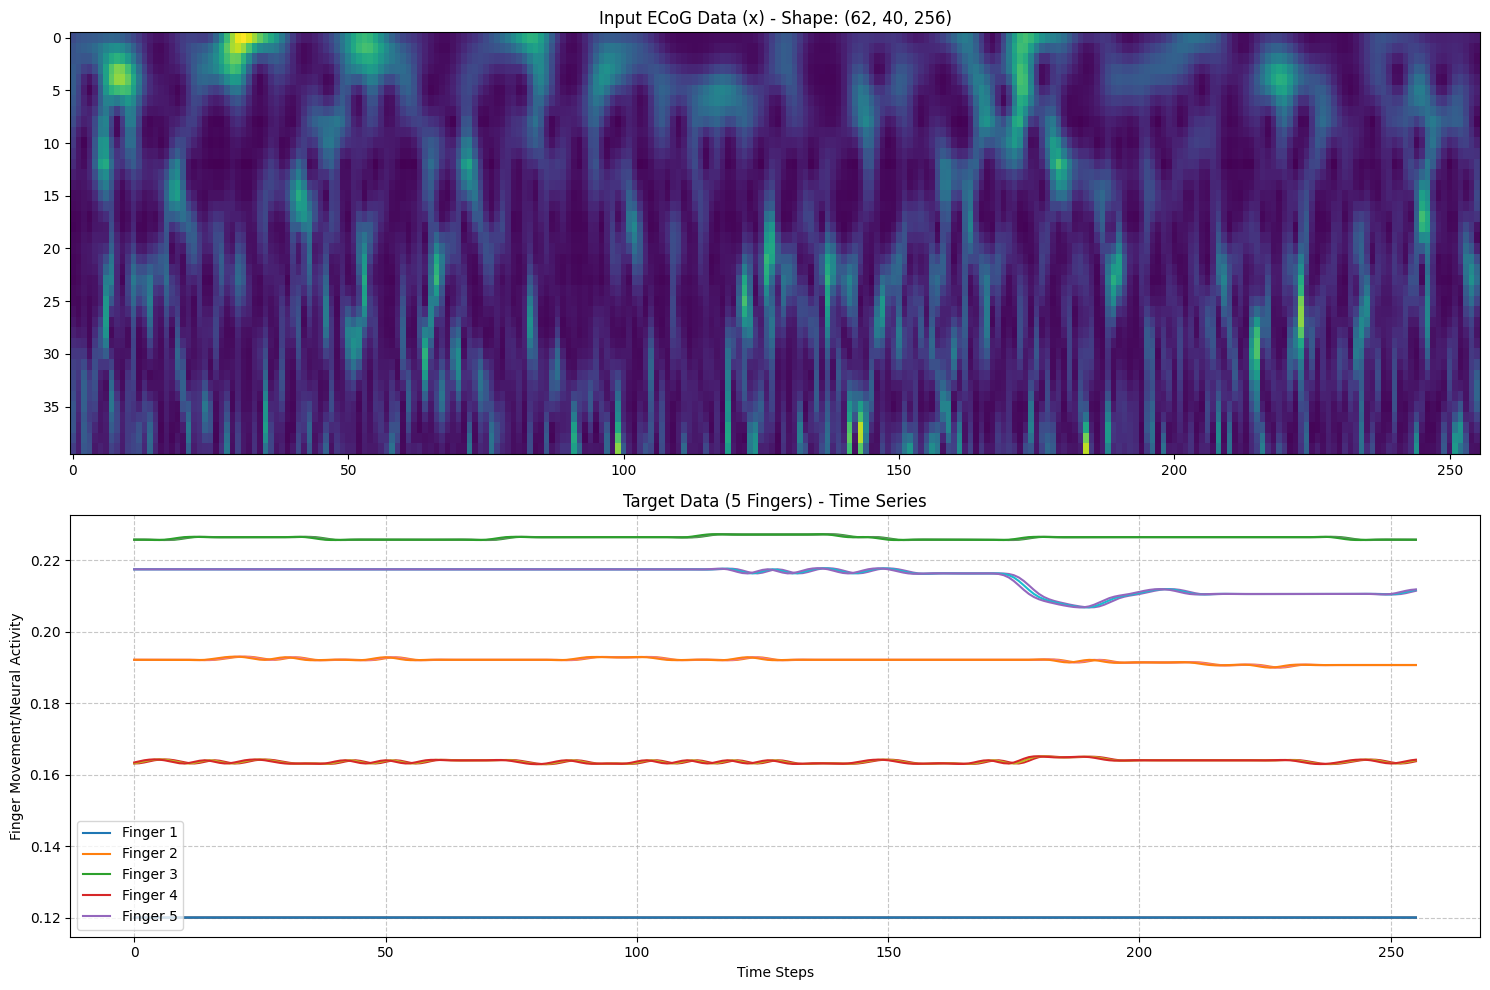

Input (x) Data Statistics:
Shape: (62, 40, 256)
Mean: 36.44956970214844
Std: 112.34618377685547
Min: -78.30249786376953
Max: 2913.20654296875

Target (y) Data Statistics:
Shape: (5, 256)
Mean: 0.18342195451259613
Std: 0.038283176720142365
Min: 0.12006422877311707
Max: 0.22728414833545685


In [7]:
def plot_ecog_data(train_dataset):
    # Assuming train_dataset is a PyTorch Dataset
    # Extract a few samples to visualize
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    # Get a few samples (let's take the first 3)
    for i in range(min(3, len(train_dataset))):
        x, y = train_dataset[i]
        
        # Plot input data (x)
        axs[0].set_title('Input ECoG Data (x) - Shape: ' + str(x.shape))
        # Assuming x is (62, 40, timeseries)
        # We'll plot a few channels/slices
        im = axs[0].imshow(x[0, :, :], aspect='auto', cmap='viridis')
        
        # Plot target data (y)
        plt.title('Target Data (5 Fingers) - Time Series')
        plt.plot(y.T)
        plt.xlabel('Time Steps')
        plt.ylabel('Finger Movement/Neural Activity')
        plt.legend([f'Finger {i+1}' for i in range(y.shape[0])])
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistical analysis
    x, y = train_dataset[0]
    print("Input (x) Data Statistics:")
    print(f"Shape: {x.shape}")
    print(f"Mean: {x.mean()}")
    print(f"Std: {x.std()}")
    print(f"Min: {x.min()}")
    print(f"Max: {x.max()}")
    
    print("\nTarget (y) Data Statistics:")
    print(f"Shape: {y.shape}")
    print(f"Mean: {y.mean()}")
    print(f"Std: {y.std()}")
    print(f"Min: {y.min()}")
    print(f"Max: {y.max()}")

# Call the visualization function
plot_ecog_data(train_dataset)

In [ ]:
import torch
import torch.nn as nn

class EncoderDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, dropout_rate=0.4):
        super(EncoderDecoder, self).__init__()
        
        # Encoder
        self.enc_block1 = ResidualBlock(input_channels, 32, kernel_size=3, dropout_rate=dropout_rate)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc_block2 = ResidualBlock(32, 64, kernel_size=3, dropout_rate=dropout_rate)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc_block3 = ResidualBlock(64, 128, kernel_size=3, dropout_rate=dropout_rate)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # LSTM with gradient clipping built in
        self.lstm = LSTM_flatten(input_size=128, hidden_size=128, num_layers=1, 
                                    bidirectional=True, batch_first=True)
        
        # Decoder
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_block1 = ResidualBlock(256, 128, kernel_size=3, dropout_rate=dropout_rate)
        
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_block2 = ResidualBlock(128 + 64, 64, kernel_size=3, dropout_rate=dropout_rate)
        
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_block3 = ResidualBlock(64 + 32, 32, kernel_size=3, dropout_rate=dropout_rate)
        
        self.final_conv = nn.Conv1d(32, output_channels, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        batch, elec, freq, time = x.shape
        x = x.reshape(batch, -1, time)
        
        # Encoder
        e1 = self.enc_block1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc_block2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_block3(p2)
        p3 = self.pool3(e3)
        
        # LSTM
        p3_permuted = p3.permute(0, 2, 1)
        lstm_out, _ = self.lstm(p3_permuted)
        lstm_out = lstm_out.permute(0, 2, 1)
        
        # Decoder
        d1 = self.up1(lstm_out)
        d1 = self.dec_block1(d1)
        
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec_block2(d2)
        
        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec_block3(d3)
        
        output = self.final_conv(d3)
        
        return output

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.4):
        super(ResidualBlock, self).__init__()
        
        padding = kernel_size // 2
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels)
        )
        
        self.skip = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()
        
        self.activation = nn.GELU()
    
    def forward(self, x):
        identity = self.skip(x)
        out = self.conv_block(x)
        out += identity
        return self.activation(out)

class LSTM_flatten(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, batch_first):
        super(LSTM_flatten, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            batch_first=batch_first
        )
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        output, hidden = self.lstm(x)
        return output, hidden

In [9]:
model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)

In [10]:
def pearson_loss(y_pred, y_true):
    return 1 - pearson_correlation_metric(y_pred, y_true)
    
def pearson_correlation_metric(y_pred, y_true):
    x = y_pred - torch.mean(y_pred)
    y = y_true - torch.mean(y_true)

    numerator = torch.sum(x * y)
    denominator = torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2))

    return numerator / (denominator + 1e-6)

def cosine_correlation_metric(x, y):
    cos_metric = nn.CosineSimilarity(dim=-1, eps=1e-08)

    cos_sim = torch.mean(cos_metric(x, y))
    return cos_sim

In [11]:
def train(model, train_loader, val_loader, num_epochs=100, lr=5e-3, device='cuda', alpha=0.5):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    train_losses, val_losses = [], []
    train_corrs, val_corrs = [], []
    pearson_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corr = 0.0
        
        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            pred = model(x)
            
            mse_loss = F.mse_loss(pred, y)
            corr = cosine_correlation_metric(pred, y)
            final_loss = alpha*mse_loss + alpha*(1. - corr)
            
            # corr = pearson_loss(pred, y)
            # final_loss = alpha * mse_loss + (1 - alpha) * corr
            
            final_loss.backward()
            optimizer.step()
            
            train_loss += final_loss.item()
            train_corr += corr.item()
        
        train_loss /= len(train_loader)
        train_corr /= len(train_loader)
        train_losses.append(train_loss)
        train_corrs.append(train_corr)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Corr: {train_corr:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corr = 0.0
        pearson_loss_sum = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                
                pred = model(x)
                
                mse_loss = F.mse_loss(pred, y)
                corr = cosine_correlation_metric(pred, y)
                final_loss = alpha*mse_loss + alpha*(1. - corr)
                
                pearson_loss_metric = pearson_correlation_metric(pred, y)
                
                # corr = pearson_loss(pred, y)
                # final_loss = alpha * mse_loss + (1 - alpha) * corr
                
                val_loss += final_loss.item()
                val_corr += corr.item()
                pearson_loss_sum += pearson_loss_metric.item()
                
        val_loss /= len(val_loader)
        val_corr /= len(val_loader)
        pearson_loss_sum /= len(val_loader)
        
        val_losses.append(val_loss)
        val_corrs.append(val_corr)
        pearson_losses.append(pearson_loss_sum)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Corr: {val_corr:.4f}, Pearson Corr: {pearson_loss_sum:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Plot correlation metrics
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_corrs, label='Train Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), val_corrs, label='Val Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), pearson_losses, label='Pearson Corr', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Training, Validation, Pearson Correlation")

    plt.tight_layout()
    plt.show()
    
    return model


Epoch 1/50 - Train Loss: 0.1554, Train Corr: 0.8804
Epoch 1/50 - Val Loss: 0.0430, Val Corr: 0.9423, Pearson Corr: 0.1518
Epoch 2/50 - Train Loss: 0.0323, Train Corr: 0.9509
Epoch 2/50 - Val Loss: 0.0375, Val Corr: 0.9463, Pearson Corr: 0.4966
Epoch 3/50 - Train Loss: 0.0143, Train Corr: 0.9772
Epoch 3/50 - Val Loss: 0.0404, Val Corr: 0.9421, Pearson Corr: 0.4740
Epoch 4/50 - Train Loss: 0.0088, Train Corr: 0.9857
Epoch 4/50 - Val Loss: 0.0386, Val Corr: 0.9438, Pearson Corr: 0.5319
Epoch 5/50 - Train Loss: 0.0063, Train Corr: 0.9898
Epoch 5/50 - Val Loss: 0.0386, Val Corr: 0.9437, Pearson Corr: 0.5303
Epoch 6/50 - Train Loss: 0.0050, Train Corr: 0.9919
Epoch 6/50 - Val Loss: 0.0400, Val Corr: 0.9420, Pearson Corr: 0.5135
Epoch 7/50 - Train Loss: 0.0040, Train Corr: 0.9936
Epoch 7/50 - Val Loss: 0.0380, Val Corr: 0.9448, Pearson Corr: 0.5220
Epoch 8/50 - Train Loss: 0.0034, Train Corr: 0.9946
Epoch 8/50 - Val Loss: 0.0399, Val Corr: 0.9417, Pearson Corr: 0.5117
Epoch 9/50 - Train Loss:

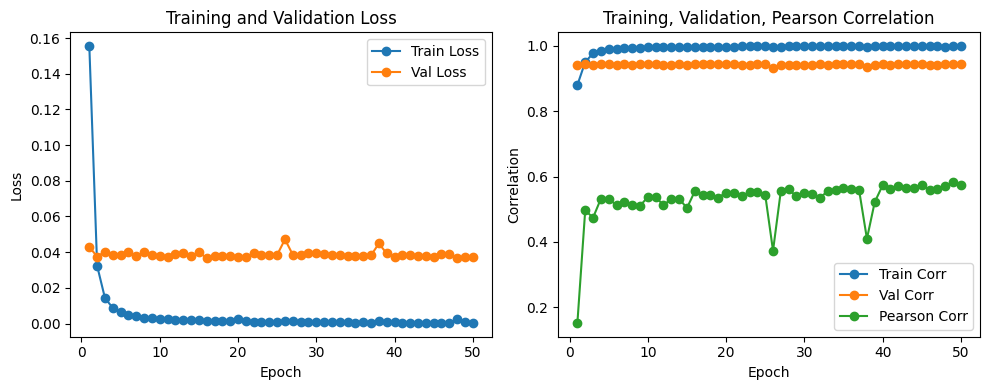

In [12]:
model = train(model, train_loader, val_loader, num_epochs=50)

In [13]:
def test_model(model, val_loader, device='cuda'):
    model.to(device)
    model.eval()

    all_actuals, all_predictions = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            pred = model(x)

            all_actuals.append(y.cpu().numpy())
            all_predictions.append(pred.cpu().numpy())

    all_actuals = np.concatenate(all_actuals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    
    all_predictions = gaussian_filter1d(all_predictions, sigma=6, axis=0)

    # Plot the entire time series
    return all_actuals, all_predictions

In [14]:
def plot_fingerwise_timeseries(actuals, predictions, time_axis, finger_labels):
    """
    Plot actual vs. predicted ECoG signals for each finger as separate time series subplots.
    
    Parameters:
    - actuals: numpy array of shape (timesteps, num_fingers)
    - predictions: numpy array of shape (timesteps, num_fingers)
    - time_axis: numpy array of shape (timesteps,), optional
    - finger_labels: list of string labels for fingers
    """
    num_fingers = actuals.shape[1]

    plt.figure(figsize=(12, 8))

    for i in range(num_fingers):
        plt.subplot(num_fingers, 1, i+1)
        plt.plot(time_axis, actuals[:, i], label='True', color='blue', alpha=0.7)
        plt.plot(time_axis, predictions[:, i], label='Prediction', color='green', alpha=0.7)

        plt.ylabel(finger_labels[i])
        
        plt.grid(True)
        
        if i == 0:
            plt.legend()

        if i == num_fingers - 1:
            plt.xlabel("Time (s)")

    plt.suptitle("Actual vs Predicted ECoG Time Series for Each Finger")
    plt.tight_layout()
    plt.show()

In [15]:
def plot_entire_timeseries(actuals, predictions):
    """
    Plot actual vs. predicted ECoG values for the entire dataset as a continuous time series.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(actuals.flatten(), label='Actual', color='blue', alpha=0.7)
    plt.plot(predictions.flatten(), label='Predicted', color='red', linestyle='dashed', alpha=0.7)
    
    plt.xlabel("Time Steps")
    plt.ylabel("ECoG Signal Value")
    plt.title("Actual vs Predicted ECoG Time Series (Test Set)")
    plt.legend()
    plt.grid(True)

    plt.show()

In [16]:
actuals, predictions = test_model(model, val_loader)
print(actuals.shape, predictions.shape)

(19724, 5, 256) (19724, 5, 256)


In [17]:
# Print pearon correlation (SotA model 0.67)
final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
print("Final Pearson Correlation: ", final_pearson)
torch.save(model, f"{final_pearson}.pth")

Final Pearson Correlation:  0.5978891849517822


C:\Users\nutri\AppData\Local\Temp\ipykernel_19516\2858757896.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\nutri\AppData\Local\Temp\ipykernel_19516\2858757896.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
d:\Downloads\project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


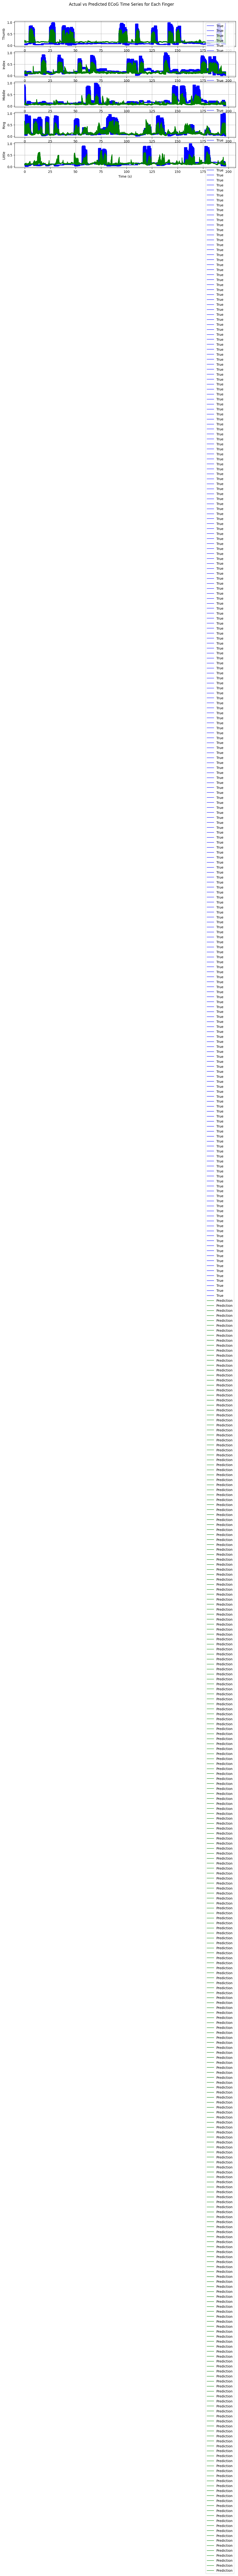

In [18]:
# Plot the actual and predicted ECoG signals for each finger
finger_labels = ['Thumb', 'Index', 'Middle', 'Ring', 'Little']
time_axis = np.arange(actuals.shape[0]) / SAMPLE_RATE # Time axis in seconds
plot_fingerwise_timeseries(actuals, predictions, time_axis=time_axis, finger_labels=finger_labels)